In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [2]:
import re
import numpy as np

In [3]:
import pandas as pd

In [4]:
import joblib
import glob
import genetools

In [5]:
import choosegpu
from malid import config
from malid.datamodels import GeneLocus

# do not use GPU - may be implicitly used by joblib imports of jax-unirep parameters?
choosegpu.configure_gpu(enable=False)

['-1']

In [6]:
from malid.embedders.unirep import UnirepFineTunedEmbedder
from malid.embedders.biotransformers import BiotransformerFineTunedEmbedding

In [7]:
config.embedder.name

'esm2_fine_tuned_cdr3'

In [8]:
def get_fold_data(output_dir):
    if issubclass(config.embedder, BiotransformerFineTunedEmbedding):
        fname = output_dir / "finetune_masked" / "version_0" / "metrics.csv"
        if not fname.exists():
            return None
        metrics = pd.read_csv(fname)

        # Multiple validation rows and training rows for each epoch
        # Step counts upwards and doesn't reset when the epoch flips
        # So convert so we have step on the epoch scale
        max_step_per_epoch = metrics.groupby("epoch")["step"].max()
        min_step_per_epoch = max_step_per_epoch.shift().fillna(0)
        metrics = pd.merge(
            metrics,
            max_step_per_epoch.rename("max_step_per_epoch"),
            left_on="epoch",
            right_index=True,
            how="left",
            validate="m:1",
        )
        metrics = pd.merge(
            metrics,
            min_step_per_epoch.rename("min_step_per_epoch"),
            left_on="epoch",
            right_index=True,
            how="left",
            validate="m:1",
        )
        metrics["normalized_step"] = (
            metrics["step"] - metrics["min_step_per_epoch"]
        ) / (metrics["max_step_per_epoch"] - metrics["min_step_per_epoch"])
        # epoch + step
        metrics["epoch_raw"] = metrics["epoch"]
        metrics["epoch"] = metrics["epoch"] + metrics["normalized_step"]

        return metrics.rename(
            columns={
                "train_loss": "training_loss",
                "train_acc": "training_accuracy",
                "val_loss": "holdout_loss",
                "val_acc": "holdout_accuracy",
            }
        )
    elif issubclass(config.embedder, UnirepFineTunedEmbedder):
        all_results = [
            joblib.load(f) for f in glob.glob(f"{output_dir}/loss.epoch.*.joblib")
        ]
        if len(all_results) == 0:
            # this was not run yet
            return None

        all_results_df = pd.DataFrame(all_results)
        # At this point each row's training_loss and holdout_loss are actually numpy arrays with single items. Weird
        # TODO: fix upstream.
        # Workaround: get single elements out
        all_results_df["training_loss"] = all_results_df["training_loss"].apply(
            lambda i: i.item()
        )
        all_results_df["holdout_loss"] = all_results_df["holdout_loss"].apply(
            lambda i: i.item()
        )
        return all_results_df.sort_values("epoch").reset_index(drop=True)
    else:
        raise ValueError(f"Unsupported embedder: {config.embedder}")

GeneLocus.BCR fold 0:	best epoch is 23 out of 25 epochs.	Ready to stop.
GeneLocus.BCR fold 1:	best epoch is 24 out of 25 epochs.	Keep running.
GeneLocus.BCR fold 2:	best epoch is 24 out of 25 epochs.	Keep running.


GeneLocus.BCR fold -1:	best epoch is 24 out of 25 epochs.	Keep running.


GeneLocus.TCR fold 0:	best epoch is 22 out of 25 epochs.	Ready to stop.
GeneLocus.TCR fold 1:	best epoch is 24.8033 out of 25 epochs.	Keep running.
GeneLocus.TCR fold 2:	best epoch is 24 out of 25 epochs.	Keep running.
GeneLocus.TCR fold -1:	best epoch is 21.8033 out of 25 epochs.	Ready to stop.


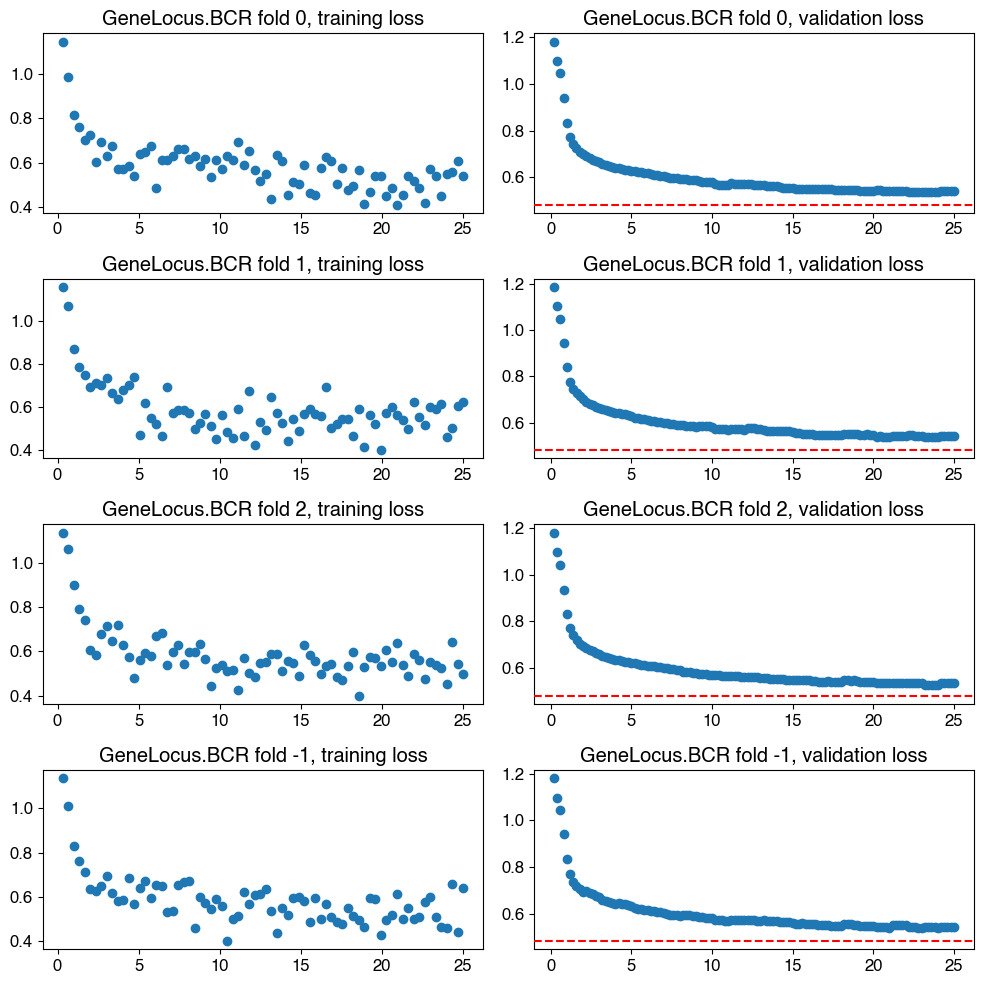

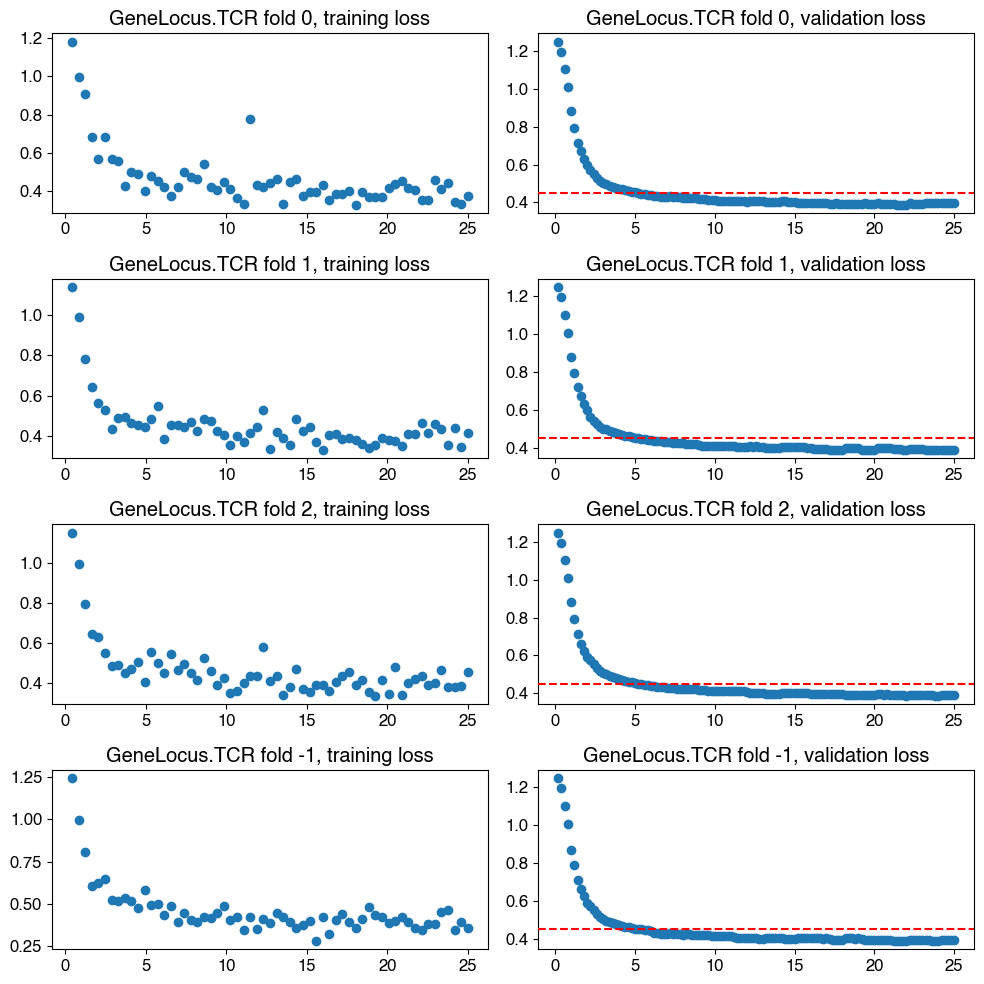

In [9]:
for gene_locus in config.gene_loci_used:
    GeneLocus.validate_single_value(gene_locus)
    fig, axarr = plt.subplots(
        nrows=len(config.all_fold_ids),
        ncols=2,
        figsize=(10, 2.5 * len(config.all_fold_ids)),
        # don't squeeze extra dimensions out from the axarr if len(config.all_fold_ids) == 1,
        # which is the case for cross validation split strategies that have study_names_for_held_out_set defined (forces single fold)
        squeeze=False,
    )
    for fold_id in config.all_fold_ids:
        output_dir = (
            config.paths.fine_tuned_embedding_dir / gene_locus.name / f"fold_{fold_id}"
        )
        all_results_df = get_fold_data(output_dir)
        if all_results_df is None:
            print(f"Not yet run: gene_locus={gene_locus}, fold={fold_id}")
            continue

        axarr[fold_id, 0].scatter(
            all_results_df["epoch"], all_results_df["training_loss"]
        )
        axarr[fold_id, 0].set_title(f"{gene_locus} fold {fold_id}, training loss")

        axarr[fold_id, 1].scatter(
            all_results_df["epoch"], all_results_df["holdout_loss"]
        )
        axarr[fold_id, 1].set_title(f"{gene_locus} fold {fold_id}, validation loss")

        # Superimpose validation loss before any fine tuning, if available
        prior_validation_loss_fname = (
            output_dir / "validation_loss_before_finetuning.txt"
        )
        if prior_validation_loss_fname.exists():
            prior_validation_loss: float = np.loadtxt(
                prior_validation_loss_fname
            ).item()
            axarr[fold_id, 1].axhline(
                y=prior_validation_loss,
                color="r",
                linestyle="dashed",
                label="Before fine tuning",
                zorder=10,
            )

        # Add early stopping - choose params from epoch with lowest validation loss, before overfitting
        # get best row
        best_results = all_results_df.iloc[all_results_df["holdout_loss"].idxmin()]
        best_epoch = best_results["epoch"]
        max_epoch = all_results_df["epoch"].max()
        ready_to_stop = max_epoch >= best_epoch + 2  # heuristic
        print(
            f"{gene_locus} fold {fold_id}:\tbest epoch is {best_epoch:n} out of {max_epoch:n} epochs.\t{'Ready to stop' if ready_to_stop else 'Keep running'}."
        )

        # save out best params / best checkpoint
        if issubclass(config.embedder, BiotransformerFineTunedEmbedding):
            # find checkpoint for best_epoch
            best_epoch_raw, best_step_raw = (
                best_results["epoch_raw"],
                best_results["step"],
            )
            checkpoint_dir = (
                output_dir / "finetune_masked" / "version_0" / "checkpoints"
            )
            best_checkpoint = list(checkpoint_dir.glob(f"epoch=*-step=*.ckpt"))

            # there should only be one checkpoint total, not to mention one checkpoint for the best epoch
            assert len(best_checkpoint) == 1
            best_checkpoint = best_checkpoint[0]

            # check that checkpoint step matches our best step, +/-
            # format is f"epoch={int(best_epoch_raw)}-step={int(best_step_raw)}.ckpt", but step number might vary slightly
            assert np.isclose(
                int(re.search(r".*step=(\d+).ckpt", str(best_checkpoint)).group(1)),
                best_step_raw,
                atol=5,
            ), f"Checkpoint {best_checkpoint} does not match epoch={int(best_epoch_raw)}, step={int(best_step_raw)}"

            # convert to absolute path so we can symlink safely
            best_checkpoint = best_checkpoint.resolve().absolute()

            # create symlink
            symlink_fname = output_dir / "finetuned.ckpt"
            symlink_fname.unlink(missing_ok=True)  # reset if symlink already exists
            symlink_fname.symlink_to(best_checkpoint)
        elif issubclass(config.embedder, UnirepFineTunedEmbedder):
            best_params = joblib.load(
                output_dir / f"params.epoch.{best_epoch:n}.joblib"
            )
            joblib.dump(
                best_params,
                output_dir / "best_params.joblib",
            )
        else:
            raise ValueError(f"Unsupported embedder: {config.embedder}")

    fig.tight_layout()
    genetools.plots.savefig(
        fig, config.paths.output_dir / f"fine_tuning.loss.{gene_locus.name}.png"
    )